In [ ]:
#default_exp ocr_dataset_sroie2019

# SROIE 2019

> Creates df of image filename -> text pairs

In [1]:
#export
from ocr.core import *
from ocr.core import save_dict, read_dict
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm

In [12]:
#export
class sroie_ocr_config:
    LINE_HEIGHT = 48
    MAIN_DIR = '../data/sroie2019/'
    LINES_DIR = '../data/ocr/'
    FILE_PATH = '../data/ocr/sroie2019_gt.pickle'
    PAD = 8 # only for training
    TEST_PAD = 1 # optional, can be set to zero

In [13]:
#export
def read_data(csv_path='images/X00016469670.txt'):
    ''' returns [([4,2], str),...] '''
    out = []
    with open(csv_path, encoding="utf8") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for line in csv_reader:
            if len(line) > 8:
                x1, y1, x2, y2, x3, y3, x4, y4 = list(map(int, line[:8]))
                label = ','.join(line[8:])
                points = np.array([ [x1, y1], [x2, y2], [x3, y3], [x4, y4] ])
                out.append([points, label])
    return out

In [16]:
#export
def preprocess_label(label):
    return label.upper()

lines_subdir = os.path.join(sroie_ocr_config.LINES_DIR, 'lines')
if not os.path.exists(lines_subdir): os.mkdir(lines_subdir)

printstats = lambda arr, s: print(s, '| mean:', arr.mean(), 'min:', arr.min(), 'max:', arr.max())

def create_lines(PAD=sroie_ocr_config.PAD, TEST_PAD=sroie_ocr_config.TEST_PAD):
    gt_dict = {}
    total = 0
    hs, ws = [], []
    for mode in ['train', 'test']:
        filenames = os.listdir(os.path.join(sroie_ocr_config.MAIN_DIR, mode + '_img'))
        for fn in tqdm(filenames, total=len(filenames)):
            gt = read_data(os.path.join(sroie_ocr_config.MAIN_DIR, mode + '_gt', fn[:-3] + 'txt'))
            im = cv2.imread(os.path.join(sroie_ocr_config.MAIN_DIR, mode + '_img', fn[:-3] + 'jpg'))
            for i, (points, label) in enumerate(gt):
                _min, _max = np.min(points, axis=0), np.max(points, axis=0)
                # pad
                pad = PAD if mode == 'train' else TEST_PAD
                _min -= pad
                _max += pad
                _max[0] += 8 # pad on right so that padding would be w/out black marks (when batching images)
                # crop tlbr
                _min[0], _min[1] = max(_min[0], 0), max(_min[1], 0)
                _max[0], _max[1] = min(_max[0], im.shape[1]), min(_max[1], im.shape[0])
                im_line = im[ _min[1]:_max[1], _min[0]:_max[0] ]

                h,w,c = im_line.shape
                hs.append(h)
                ws.append(w)
                new_w = int(w * sroie_ocr_config.LINE_HEIGHT / float(h))
                if h < 10+pad*2 or (new_w/4-2) < 1: # or len(label) == 1:
#                     plot(im)
                    plot(im_line)
#                     print(points, [label], [h,w,c])
#                     print(_min, _max, im.shape)
                    continue
#                 im_line = cv2.resize(im_line, (new_w, sroie_ocr_config.LINE_HEIGHT))

                line_fn = fn[:-3] + str(i) + '.jpg'
                gt_dict[line_fn] = (preprocess_label(label), mode, 'sroie2019')
                cv2.imwrite(os.path.join(sroie_ocr_config.LINES_DIR, 'lines', line_fn), im_line)
                total += 1
    save_dict(gt_dict, sroie_ocr_config.FILE_PATH)
    printstats(np.array(hs), 'height')
    printstats(np.array(ws), 'width')
    print(total)

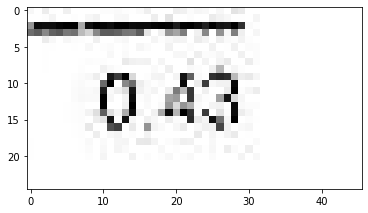

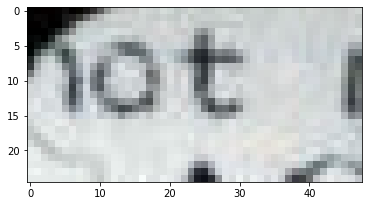

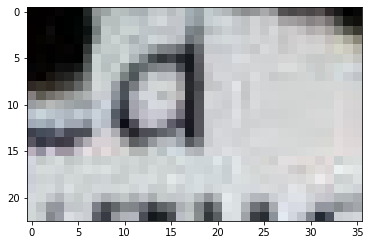

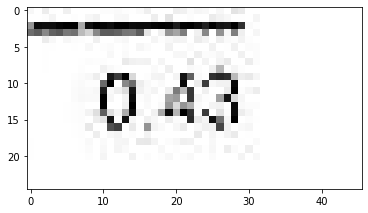

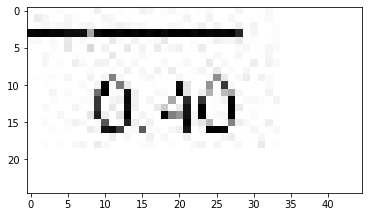

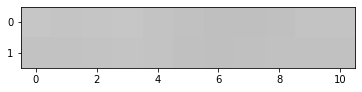

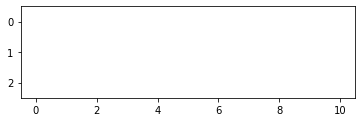

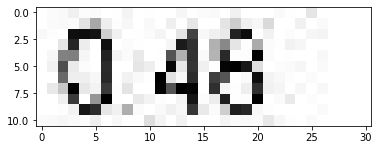

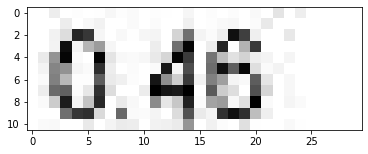


height | mean: 47.1850255713315 min: 2 max: 507
width | mean: 226.32008869496798 min: 11 max: 1722
55913


In [17]:
create_lines()

In [5]:
#export
# NOTE: fn2label[fn] returns tuple (str(label), str(mode)), where mode = 'train'/'test'
def get_fn2label():
     return read_dict(os.path.join(sroie_ocr_config.LINES_DIR, 'sroie2019_gt.pickle'))

In [6]:
len(get_fn2label())

55920

In [7]:
#export
DATA_PATH = os.path.join(sroie_ocr_config.LINES_DIR, 'lines')

In [8]:
#export
def create_df(fn2label=None):
    if fn2label is None: fn2label = get_fn2label()
    data = []
    for fn, (label, data_split, dataset_desc) in fn2label.items():
        data.append((fn, label, data_split == 'test', dataset_desc))
    return pd.DataFrame(data, columns=['image_path', 'string', 'valid', 'dataset'])

In [9]:
main_df = create_df()
main_df.head()

,image_path,string,valid,dataset
0,X51006327978.0.jpg,Y SOON FATT S/B (81497-P),False,sroie2019
1,X51006327978.1.jpg,"LOT 1504, BATU 8 1/2, JALAN KLANG LAMA,",False,sroie2019
2,X51006327978.2.jpg,"46000 PETALING JAYA, SELANGOR.",False,sroie2019
3,X51006327978.3.jpg,TEL : 016-2014209,False,sroie2019
4,X51006327978.4.jpg,GST REG NO : 000788250624,False,sroie2019


In [10]:
char_freq = defaultdict(lambda: 0)
for string in main_df['string']:
    for char in string:
        char_freq[char] += 1
char_freq = dict(char_freq)

In [20]:
char_freq = dict(sorted(char_freq.items(), key=lambda k:k[1]))
print(char_freq)

{'`': 1, '·': 1, '{': 3, '}': 3, '\\': 6, '|': 6, ';': 12, '<': 13, '>': 15, '^': 19, '_': 19, '\n': 20, '~': 24, '?': 26, '[': 66, ']': 66, '"': 166, '+': 229, '=': 324, '!': 381, "'": 408, '#': 625, '$': 648, '&': 707, 'Z': 768, '@': 1165, 'Q': 1167, '*': 1473, '%': 1831, 'W': 2910, 'J': 2992, 'V': 3438, '/': 3797, 'F': 3843, ',': 4191, 'X': 4732, ')': 4751, '(': 4766, 'K': 4998, '-': 5566, 'Y': 6216, 'B': 6544, '9': 7544, '7': 8285, '8': 9326, 'P': 9432, '4': 9437, '6': 9660, 'H': 9737, ':': 10516, '5': 10837, '3': 11966, 'G': 12409, 'U': 12589, 'D': 12721, 'C': 14645, '2': 15001, 'M': 15211, 'L': 17481, '.': 19307, 'I': 21104, '1': 22127, 'R': 23724, 'O': 25649, 'N': 26187, 'S': 28138, 'E': 30652, 'T': 32246, 'A': 40094, '0': 42829, ' ': 64128}


In [ ]:
#export
char_freq = {'`': 1, '·': 1, '{': 3, '}': 3, '\\': 6, '|': 6, ';': 12, '<': 13, 
             '>': 15, '^': 19, '_': 19, '\n': 20, '~': 24, '?': 26, '[': 66, ']': 66, 
             '"': 166, '+': 229, '=': 324, '!': 381, "'": 408, '#': 625, '$': 648, '&': 
             707, 'Z': 768, '@': 1165, 'Q': 1167, '*': 1473, '%': 1831, 'W': 2910, 'J': 2992, 
             'V': 3438, '/': 3797, 'F': 3843, ',': 4191, 'X': 4732, ')': 4751, '(': 4766, 
             'K': 4998, '-': 5566, 'Y': 6216, 'B': 6544, '9': 7544, '7': 8285, '8': 9326, 
             'P': 9432, '4': 9437, '6': 9660, 'H': 9737, ':': 10516, '5': 10837, '3': 11966, 
             'G': 12409, 'U': 12589, 'D': 12721, 'C': 14645, '2': 15001, 'M': 15211, 'L': 17481, 
             '.': 19307, 'I': 21104, '1': 22127, 'R': 23724, 'O': 25649, 'N': 26187, 'S': 28138, 
             'E': 30652, 'T': 32246, 'A': 40094, '0': 42829, ' ': 64128}

In [12]:
chars = [k for k in char_freq.keys()]
label_delim = '`'
label_delim in chars

True

In [36]:
allowed_chars = set(chars + [label_delim]) - set(['·', '`'])
print(allowed_chars)
len(allowed_chars)

{'N', '1', '[', 'I', '|', 'Y', '9', 'F', '"', '\n', 'W', '5', '@', ')', 'T', 'S', "'", '$', '%', ' ', 'U', 'G', '8', 'A', ';', 'B', '>', '*', '.', '&', 'X', 'D', '4', '!', '?', 'J', '#', 'Z', 'O', '3', '/', 'P', '}', 'H', 'E', '2', '+', '\\', '_', '7', 'L', '0', '(', 'Q', '<', ':', '^', ',', 'V', '=', '{', '6', 'C', 'M', '-', '~', 'K', 'R', ']'}


69

In [40]:
#export
allowed_chars = ['N', '1', '[', 'I', '|', 'Y', '9', 'F', '"', '\n', 'W', '5', '@', ')', 'T', 'S', "'", 
                 '$', '%', ' ', 'U', 'G', '8', 'A', ';', 'B', '>', '*', '.', '&', 'X', 'D', '4', '!', 
                 '?', 'J', '#', 'Z', 'O', '3', '/', 'P', '}', 'H', 'E', '2', '+', '\\', '_', '7', 'L', 
                 '0', '(', 'Q', '<', ':', '^', ',', 'V', '=', '{', '6', 'C', 'M', '-', '~', 'K', 'R', ']']